experiments on reading **optimization algorithms on matrix manifold**

$$ \min: x^T A x $$

$$ s.t.\quad x \in S^{n-1} $$

In [178]:
from fn import F

import numpy as np
import scipy.linalg as la 
import matplotlib.pyplot as plt 

%matplotlib inline
plt.style.use('ggplot')

retraction: 
$$R_x(\xi) = \frac {x+ \xi} {|x+ \xi|}$$

tangent projection:
$$ P_x(\xi) = (I-xx^T)\xi $$

gradient:

$$ \nabla \bar f(x) = Ax $$
$$ \nabla f(x) = P_x \nabla \bar f(x) $$

In [179]:
def retraction(x, ξ):
    return (x+ ξ)/ la.norm(x+ ξ)

def project_to_tangent_space(x, ξ):
    return (np.eye(x.shape[0])- x.dot(x.T)).dot(ξ)

In [180]:
def cost_function(A, x):
    return x.T.dot(A).dot(x)[0, 0]

def embedding_gradient(A, x):
    return 2* A.dot(x)

In [181]:
# line search
def line_search(A, x0):
    α, β, σ = 2, .5, .5 # line search parameters
    ϵ_f, ϵ_g = 1e-4, 1e-4 # terminate check
    
    xs = [x0]
    ITERATIONS, INNER_ITERATIONS = 20, 10
    terminate = False
    state = 'continue'
    
    for i in range(ITERATIONS):
        x = xs[-1]
        η = -project_to_tangent_space(x, embedding_gradient(A, x)) # descent
        
        # find armijo step size
        state = 'diverge'
        for m in range(INNER_ITERATIONS):
            ratio = α* β**m
            x_new = retraction(x, ratio* η)
            model_decrease = -σ * ratio * η.T.dot(η)[0, 0]
            actual_decrease = cost_function(A, x_new)- cost_function(A, x)
            
            if actual_decrease< model_decrease:
                # okay
                xs.append(x_new)
                state = 'converge' if abs(actual_decrease)< ϵ_f else 'continue'
                break
        if state!='continue':
            break
            
    print(f'terminate after {i} iterations, state: {state}')
    return xs

terminate after 19 iterations, state: continue


(array([[-0.02886587, -0.69439841, -0.0969186 ,  0.71244958]]),
 (array([1.09183724e+02+0.j, 2.53328460e+01+0.j, 9.24768442e-02+0.j,
         3.90953508e-01+0.j]),
  array([[ 0.49673179,  0.34310395, -0.75672651, -0.2508031 ],
         [ 0.35725595, -0.624671  ,  0.17406996, -0.67220085],
         [ 0.64687431,  0.45637135,  0.60613754,  0.07665577],
         [ 0.45516958, -0.53272038, -0.17222639,  0.69236386]])))

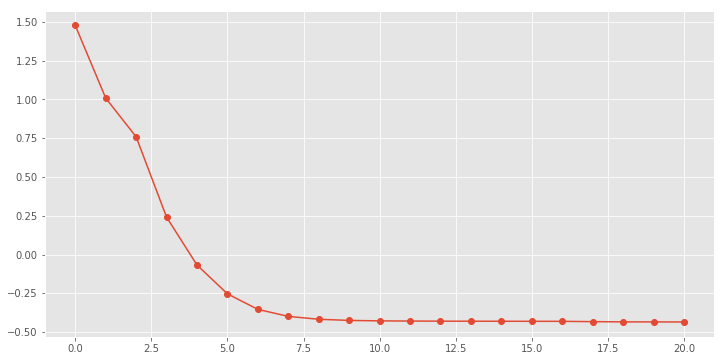

In [182]:
# test line search
# A = np.c_[[1, 2, 3], [2, 2, 1], [3, 1, 3]]
# x = np.c_[[0, 0, 1]]
A = np.c_[[1, 2, 3, 4], [4, 2, 2, 0], [1, 3, 4, 5], [4, 3, 2, 1]] 
A = A.T.dot(A)
x = np.c_[[0, 0, 0, 1]]
xs = line_search(A, x)

plt.figure(figsize=(12, 6))
plt.plot(list(map(F()>>(cost_function, A)>> np.log10, xs)), '-o')
xs[-1].T, la.eig(A)

Newton's method

connection:
$$\nabla_\eta\xi = P_x(D\xi(x)[\eta])$$

apply to vector field: $\xi:= grad\ f$: 
$$\nabla_\eta grad\ f(x) = P_x(D(2(I-x x^T)* Ax)[\eta])$$
$$ = P_x((A- (I\cdot x^TAx- Axx^T))\eta)$$
$$ = 2P_x(A\eta- \eta\ x^TAx)\quad =\quad 2P_x(AP_x\eta- \eta x^TAx)$$ 

give equations:
$$ \left\{\begin{matrix}
P_xAx+ (P_xAP_x\eta- \eta x^TAx)= 0
\\ x^T\eta = 0
\end{matrix}\right.
$$

In [183]:
# newton's method
def newton_method(A, x0):
    ITERATIONS = 20
    
    dim, xs = x0.shape[0], [x0]
    E, b = np.zeros((dim+1, dim)), np.zeros((dim+1, 1)) # E \eta = b
    for i in range(ITERATIONS):
        x = xs[-1]
        
        # construct iteration equations
        P_x = np.eye(dim)- x.dot(x.T)
        E[:dim, :] = P_x.dot(A).dot(P_x)- x.T.dot(A).dot(x)
        E[-1, :] = x.T
        b[:dim, :] = -P_x.dot(A).dot(x)
        
        # eta = la.solve(E, b)
        eta, res, rank, s = la.lstsq(E, b) # eta may not in tangent space
        eta = project_to_tangent_space(x, eta)
        x_new = retraction(x, eta)
        xs.append(x_new)
        if abs(cost_function(A, x_new)- cost_function(A, x))< 1e-4:
            print('converge')
            break
        
    return xs

converge


(array([[ 0.75628053, -0.17526138, -0.60600012,  0.17345621]]),
 (array([1.09183724e+02+0.j, 2.53328460e+01+0.j, 9.24768442e-02+0.j,
         3.90953508e-01+0.j]),
  array([[ 0.49673179,  0.34310395, -0.75672651, -0.2508031 ],
         [ 0.35725595, -0.624671  ,  0.17406996, -0.67220085],
         [ 0.64687431,  0.45637135,  0.60613754,  0.07665577],
         [ 0.45516958, -0.53272038, -0.17222639,  0.69236386]])))

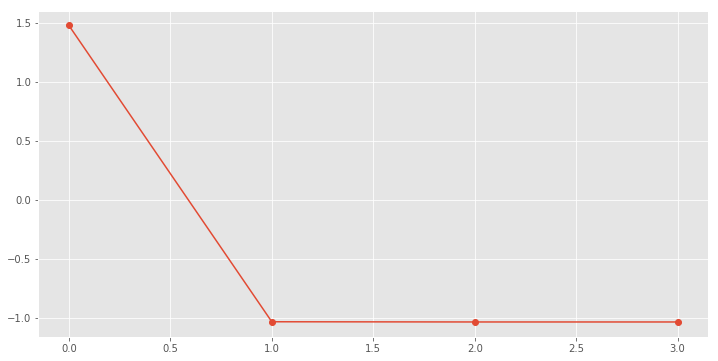

In [184]:
# test newton's method 
# A = np.c_[[1, 2, 3], [2, 2, 1], [3, 1, 3]]
# x = np.c_[[0, 0, 1]]
A = np.c_[[1, 2, 3, 4], [4, 2, 2, 0], [1, 3, 4, 5], [4, 3, 2, 1]] 
A = A.T.dot(A)
x = np.c_[[0, 0, 0, 1]]

xs = newton_method(A, x)
plt.figure(figsize=(12, 6))
plt.plot(list(map(F()>>(cost_function, A)>>np.log10, xs)), '-o')
xs[-1].T, la.eig(A)

In [185]:
x = xs[-1]
x.T.dot(A).dot(x)

array([[0.09247778]])

In [50]:
np.eye(3)- x.dot(x.T)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [10]:
x = np.c_[[1, 2, 3]]

In [13]:
x.T.dot(x)[0, 0]

14

In [60]:
x.shape

(3, 1)

In [66]:
embedding_gradient(A, x)

array([[6],
       [2],
       [6]])

In [72]:
project_to_tangent_space(np.c_[[6, 2, 6]], x).T.dot(x)

array([[-35.]])

In [74]:
project_to_tangent_space(np.c_[[1, 2, 3]], x).T.dot(x)

array([[-8.]])

In [55]:
(np.eye(3)- x.dot(x.T)).dot(np.c_[[6, 2, 6]]).T.dot(x)

array([[0.]])

In [32]:
x.dot(x.T)

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])